In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_excel("/content/drive/MyDrive/ML_3/train.xlsx")
df.head(10)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


Сортируем датасет, чтобы лаги были корректными

In [3]:
df = df.sort_values(by='dt').reset_index(drop=True)
df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [4]:
df.shape

(400, 2)

нулевых значений нет

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


# Проверка на стационарность, авторкорреляцию

<Axes: ylabel='Цена на арматуру'>

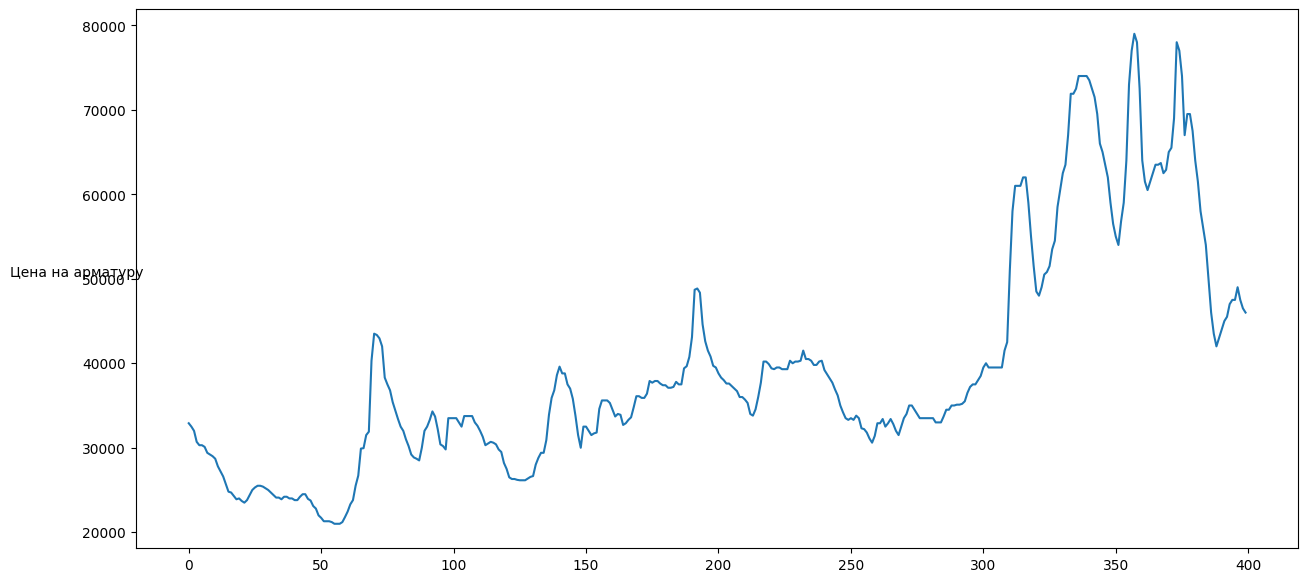

In [6]:
plt.figure(figsize=(15, 7))
plt.ylabel('Цена на арматуру', rotation=0)
df['Цена на арматуру'].plot()

Судя по графику, временной ряд случайный. Однако, можно предположить, что он все таки увеличивается. Чтобы не гадать, можно это проверить

In [7]:
!pip install statsmodels==0.14.4

In [8]:
df["Цена на арматуру"]

,Цена на арматуру
0,32900
1,32500
2,32000
3,30700
4,30300
...,...
395,47500
396,49000
397,47500
398,46500


In [9]:
df.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [10]:
df['Цена на арматуру'].describe()

,Цена на арматуру
count,400.000000
mean,39229.475000
std,13407.979668
min,21000.000000
25%,31075.000000
50%,35450.000000
75%,42000.000000
max,79000.000000


Приводим дату к формату даты и делаем её индексом

In [11]:
df['dt'] = pd.to_datetime(df['dt'], format='%m-%d-%Y')

df = df.set_index(['dt'])

Разложение ряда на компоненты

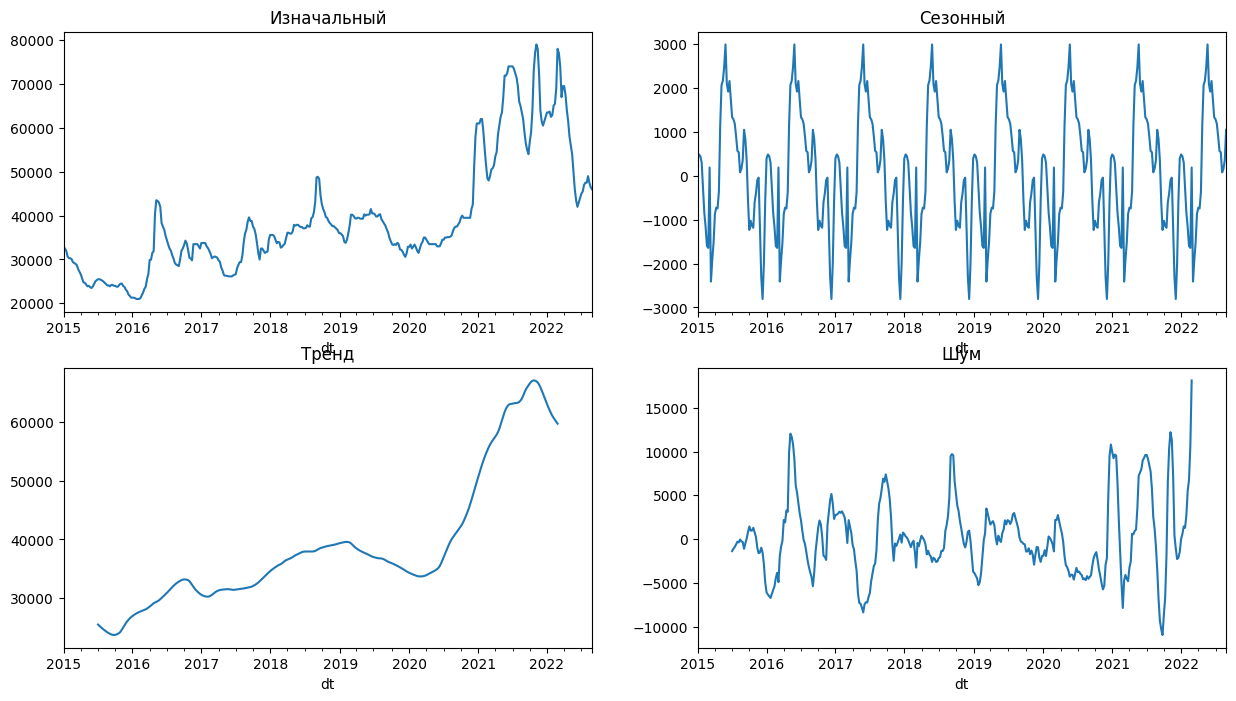

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

decompose = seasonal_decompose(df[['Цена на арматуру']])

ax[0, 0].set_title('Изначальный')
ax[0, 1].set_title('Сезонный')
ax[1, 0].set_title('Тренд')
ax[1, 1].set_title('Шум')

decompose.observed.plot(ax=ax[0, 0])
decompose.seasonal.plot(ax=ax[0, 1])
decompose.trend.plot(ax=ax[1, 0])
decompose.resid.plot(ax=ax[1, 1]);


Тест на стационарность

In [13]:
from statsmodels.tsa.stattools import adfuller, acf

result = adfuller(df['Цена на арматуру'])

print('ADF Statistic:', result[0])
print('p-value:', result[1])


ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155


можно предположить, т.к. p > 0.05, что временной ряд нестационарен
Надо убрать тренд и сезонность

Автокорреляция и частичная автокорреляция

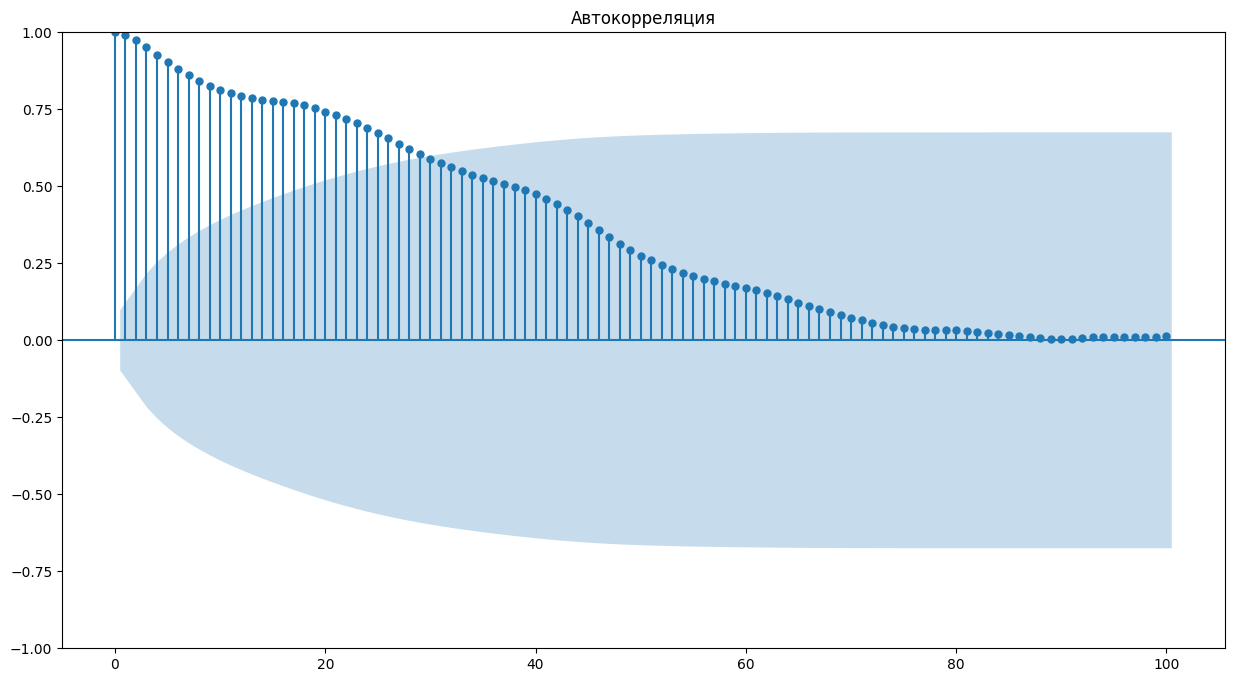

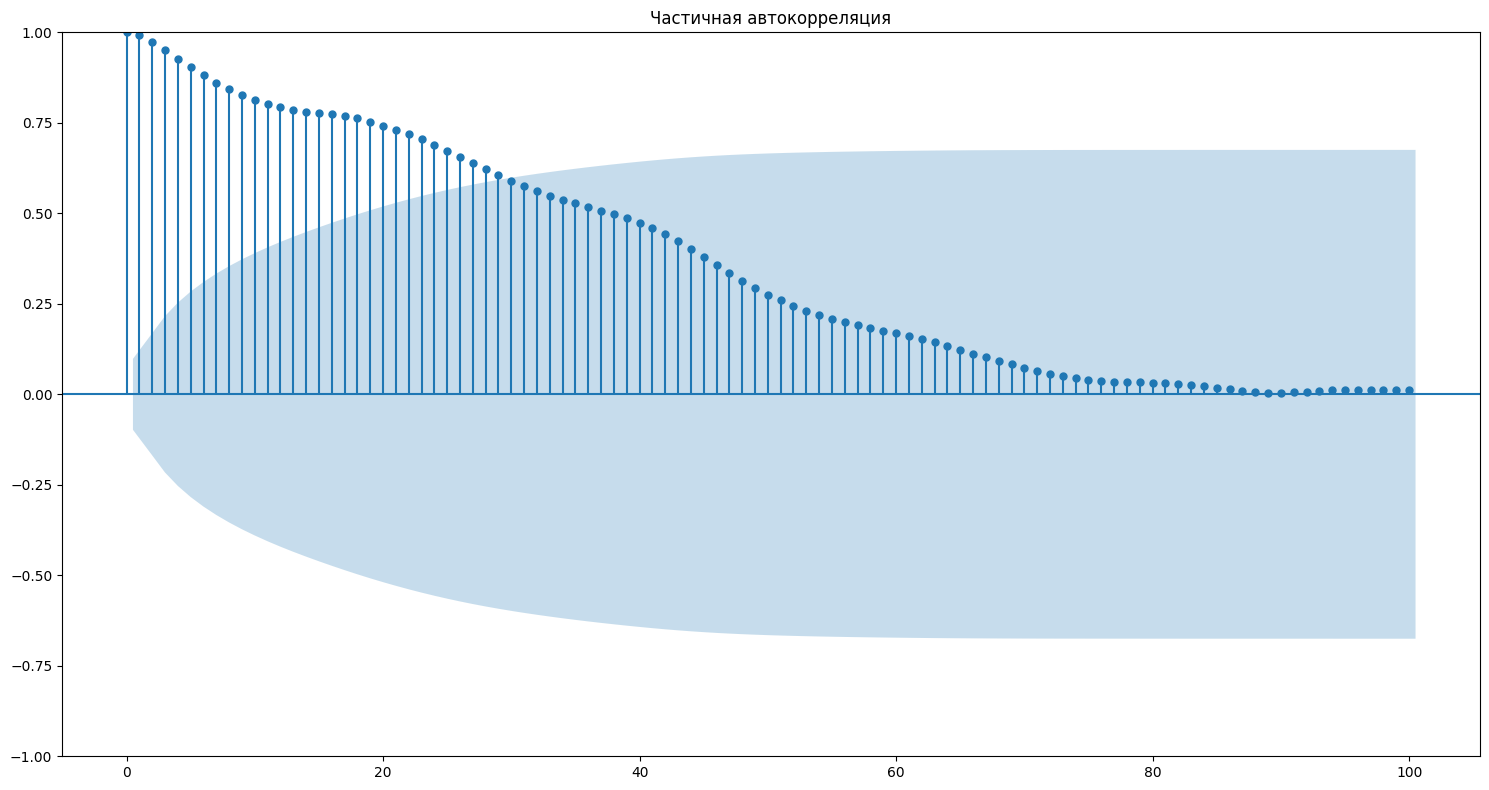

In [14]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15,8))
plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Автокорреляция')

plt.figure(figsize=(15,8))

plot_acf(df['Цена на арматуру'], lags=100, ax=plt.gca())
plt.title('Частичная автокорреляция')

plt.tight_layout()
plt.show()

# Работа с выбросами

<Axes: >

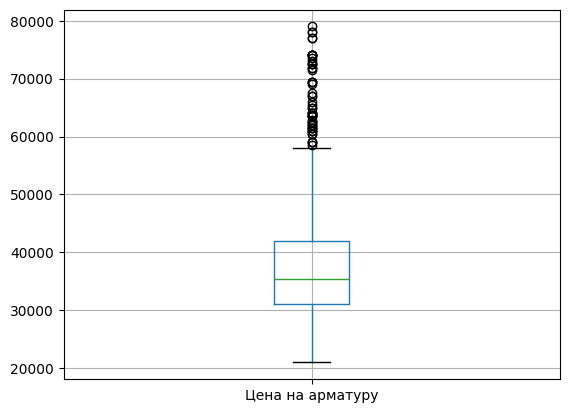

In [15]:
df.boxplot()

# Замена выбросов



Данных очень мало. Так что просто удалить выбросы было бы слишком затратно

Поэтому, можно поробовать сгладить или заменить выбросы с помощью линейной интерполяции или скользящего среднего

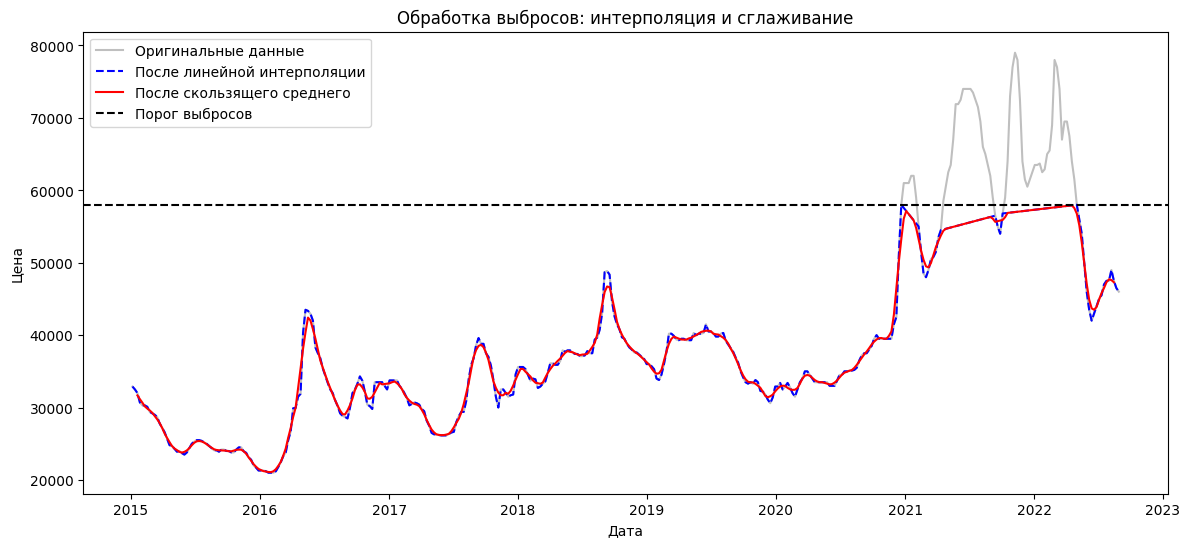

In [16]:

threshold = 58000
outliers = df['Цена на арматуру'] > threshold

df['Цена_Clean'] = df['Цена на арматуру'].copy()
df.loc[outliers, 'Цена_Clean'] = np.nan
df['Цена_Clean'] = df['Цена_Clean'].interpolate(method='linear')


df['Цена_Smooth'] = df['Цена_Clean'].rolling(window=5, center=True).mean()

plt.figure(figsize=(14, 6))

plt.plot(df.index, df['Цена на арматуру'], label="Оригинальные данные", alpha=0.5, color="gray")
plt.plot(df.index, df["Цена_Clean"], label="После линейной интерполяции", linestyle="--", color="blue")
plt.plot(df.index, df["Цена_Smooth"], label="После скользящего среднего", linestyle="-", color="red")

plt.axhline(y=threshold, color="black", linestyle="--", label="Порог выбросов")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена")
plt.title("Обработка выбросов: интерполяция и сглаживание")
plt.show()

Лучше всего справилась линейная интерполяция, т.к выбросов не осталось и пропущенных значений тоже

<Axes: >

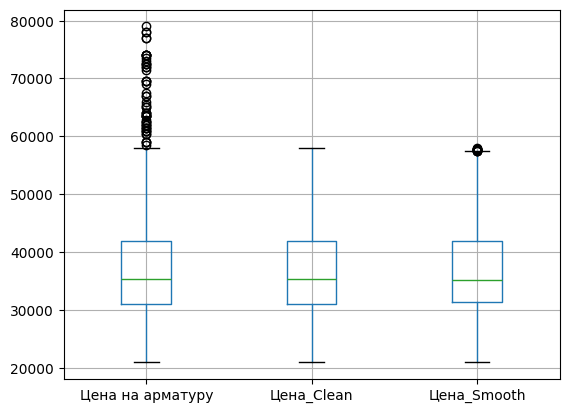

In [17]:
df.boxplot()

Колонки, которые были преобразованы с помощью линейной интерполяции и скользящего среднего, можно использовать как признаки для обучения модели, и давать в качестве Y оригинальные цены

In [18]:
df

,Цена на арматуру,Цена_Clean,Цена_Smooth
dt,,,
2015-01-05,32900,32900.0,NaN
2015-01-12,32500,32500.0,NaN
2015-01-19,32000,32000.0,31680.0
2015-01-26,30700,30700.0,31160.0
2015-02-02,30300,30300.0,30680.0
...,...,...,...
2022-08-01,47500,47500.0,47700.0
2022-08-08,49000,49000.0,47600.0
2022-08-15,47500,47500.0,47300.0


# Преобразование временного ряда в стационарный

Надо сделать стационарный временной ряд, и использовать его как признак при обучении модели


Дифференцирование

In [19]:
df['Цена_dif_1'] = df['Цена на арматуру'].diff(1)
df['Цена_dif_2'] = df['Цена на арматуру'].diff(2)

Логарифмирование

In [20]:
df['Цена_log'] = np.log(df['Цена на арматуру'])

Преобразование Бокса-Кокса

In [21]:
from scipy.stats import boxcox

df['Цена_BoxCox'], lambda_bc = boxcox(df['Цена на арматуру'] + 1)
print(f'Оптимальный λ: {lambda_bc}')

Оптимальный λ: -0.730005610503332


In [22]:
df

,Цена на арматуру,Цена_Clean,Цена_Smooth,Цена_dif_1,Цена_dif_2,Цена_log,Цена_BoxCox
dt,,,,,,,
2015-01-05,32900,32900.0,NaN,NaN,NaN,10.401228,1.369162
2015-01-12,32500,32500.0,NaN,-400.0,NaN,10.388995,1.369156
2015-01-19,32000,32000.0,31680.0,-500.0,-900.0,10.373491,1.369148
2015-01-26,30700,30700.0,31160.0,-1300.0,-1800.0,10.332018,1.369126
2015-02-02,30300,30300.0,30680.0,-400.0,-1700.0,10.318903,1.369119
...,...,...,...,...,...,...,...
2022-08-01,47500,47500.0,47700.0,0.0,500.0,10.768485,1.369324
2022-08-08,49000,49000.0,47600.0,1500.0,1500.0,10.799576,1.369336
2022-08-15,47500,47500.0,47300.0,-1500.0,0.0,10.768485,1.369324


Экспоненциальное сглаживание

In [23]:
alpha = 0.4

exp_smoothing = [df['Цена на арматуру'].iloc[0]]

for i in range(1, len(df['Цена на арматуру'])):
  exp_smoothing.append(alpha*df['Цена на арматуру'].iloc[i] + (1-alpha)*exp_smoothing[i-1])

print(exp_smoothing[-2])

47182.1182616193


In [24]:
df['exp_smoothing'] = exp_smoothing


Авторегрессия

In [25]:
from statsmodels.tsa.ar_model import AutoReg

auto_reg_model = AutoReg(df['Цена на арматуру'], lags=[1, 5, 10, 15]).fit()

df['Цена_AR'] = auto_reg_model.fittedvalues

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-MON will be used.
  self._init_dates(dates, freq)


Лаги

In [26]:
for lag in range(1, 6):
  df[f'lag_{lag}'] = df['Цена на арматуру'].shift(lag)

Временные признаки

In [27]:
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day         # день месяца (1-31)
df['weekofyear'] = df.index.isocalendar().week  # номер недели в году (1-52)
df['dayofweek'] = df.index.dayofweek  # день недели (0 = Пн, 6 = Вс)
df['quarter'] = df.index.quarter  # квартал (1-4)

Разделение на обучающую и тестовую выборку

In [28]:

train_size = int(len(df)*0.7)
train, test = df.iloc[:train_size], df.iloc[train_size:]

print(f"Размер обучающей выборки: {train.shape}")
print(f"Размер тестовой выборки: {test.shape}")

Размер обучающей выборки: (280, 20)
Размер тестовой выборки: (120, 20)


Разделение на тестовую и обучающую с признаками

In [29]:
df.columns

Index(['Цена на арматуру', 'Цена_Clean', 'Цена_Smooth', 'Цена_dif_1',
       'Цена_dif_2', 'Цена_log', 'Цена_BoxCox', 'exp_smoothing', 'Цена_AR',
       'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'year', 'month', 'day',
       'weekofyear', 'dayofweek', 'quarter'],
      dtype='object')

In [30]:
features = ['Цена_Clean', 'Цена_Smooth', 'Цена_dif_1',
            'Цена_dif_2', 'Цена_log', 'Цена_BoxCox',
            'exp_smoothing', 'Цена_AR',
            'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
            'year', 'month', 'day',
            'weekofyear', 'dayofweek', 'quarter']

X_train = train[features]
Y_train = train['Цена на арматуру']
X_test = test[features]
Y_test = test['Цена на арматуру']

Почему-то CatBoost с Numpy не хотят совмещаться:(((((

In [37]:
!pip install numpy==1.23.5 catboost==1.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 110.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 4.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 2.0.5 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albucore 0.0.23 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.21.1 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have 

0:	learn: 5603.5648880	test: 25477.7467034	best: 25477.7467034 (0)	total: 498us	remaining: 498ms
100:	learn: 495.1869477	test: 15225.3096315	best: 15225.3096315 (100)	total: 39.2ms	remaining: 349ms
200:	learn: 233.1532537	test: 14159.5367088	best: 14159.5367088 (200)	total: 77.2ms	remaining: 307ms
300:	learn: 176.8166308	test: 13997.0604534	best: 13996.9153432 (299)	total: 117ms	remaining: 272ms
400:	learn: 141.2085478	test: 13934.5192415	best: 13934.3808983 (399)	total: 156ms	remaining: 233ms
500:	learn: 113.7422777	test: 13914.5099463	best: 13914.5099463 (500)	total: 198ms	remaining: 197ms
600:	learn: 95.8633235	test: 13895.5340510	best: 13894.7476028 (591)	total: 237ms	remaining: 158ms
700:	learn: 81.8784189	test: 13884.9231606	best: 13884.6467938 (698)	total: 277ms	remaining: 118ms
800:	learn: 71.4914839	test: 13876.7270473	best: 13876.4381478 (798)	total: 318ms	remaining: 79ms
900:	learn: 63.0829285	test: 13874.1332689	best: 13874.0708137 (882)	total: 358ms	remaining: 39.3ms
999:	

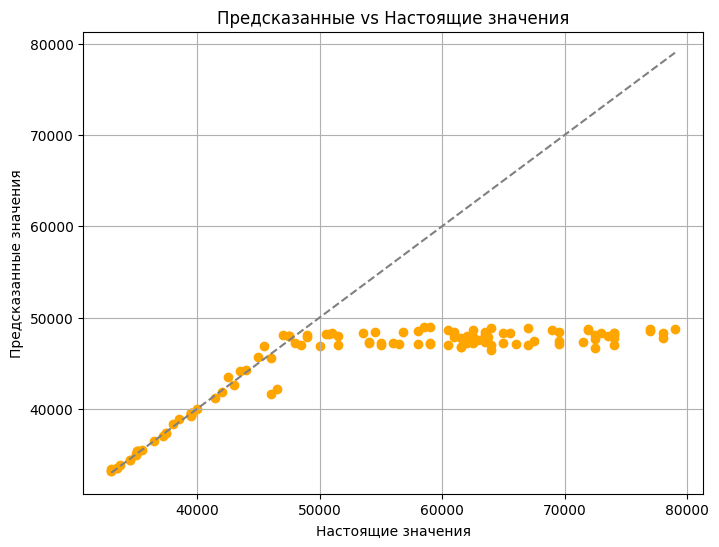

In [36]:

from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score




catboost_regressor_model = CatBoostRegressor(
    iterations=1000,  # кол.итераций
    learning_rate=0.05,  # скорость обучения
    depth=3,  # глубина деревьев
    l2_leaf_reg=3,  # регулярзация
    eval_metric='RMSE', # метрика
    early_stopping_rounds=50,
    verbose=100
)

catboost_regressor_model.fit(X_train, Y_train, eval_set=(X_test, Y_test))

Y_pred = catboost_regressor_model.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred)
rmse = mse ** 0.5


r2 = r2_score(Y_test, Y_pred)


print(f'MSE: {mse:.4f}')
print(f'RMSE: {rmse:.4f}')
print(f'R²: {r2:.4f}')


plt.figure(figsize=(8, 6))
plt.scatter(Y_test, Y_pred, color='orange')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], linestyle='--', color='gray')
plt.xlabel('Настоящие значения')
plt.ylabel('Предсказанные значения')
plt.title('Предсказанные vs Настоящие значения')
plt.grid()
plt.show()

Надо улучшить показатели модели, привести ряд к стационарному виду, возможно избавиться от выбросов и предсказать на сколько там недель закупать арматуру

Поиск лучших параметров для модели

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [3, 5, 7, 10],
    'iterations': [500, 1000]
}

grid_search = GridSearchCV(estimator=catboost_regressor_model, param_grid=param_grid, cv=3)
grid_search.fit(X_train, Y_train, eval_set=(X_test, Y_test))
print(grid_search.best_params_)

0:	learn: 4265.0724409	test: 23679.7752012	best: 23679.7752012 (0)	total: 1ms	remaining: 499ms
100:	learn: 2202.8268126	test: 20553.5341298	best: 20553.5341298 (100)	total: 33ms	remaining: 131ms
200:	learn: 1259.4730051	test: 18197.4418117	best: 18197.4418117 (200)	total: 64.3ms	remaining: 95.7ms
300:	learn: 787.4989906	test: 16575.4192375	best: 16575.4192375 (300)	total: 93.7ms	remaining: 61.9ms
400:	learn: 526.5164131	test: 15604.7954948	best: 15604.7954948 (400)	total: 123ms	remaining: 30.4ms
499:	learn: 369.2829348	test: 15012.5413901	best: 15012.5413901 (499)	total: 153ms	remaining: 0us

bestTest = 15012.54139
bestIteration = 499

0:	learn: 6606.3028217	test: 25884.8437614	best: 25884.8437614 (0)	total: 404us	remaining: 202ms
100:	learn: 3128.6388616	test: 21653.1383371	best: 21653.1383371 (100)	total: 33ms	remaining: 130ms
200:	learn: 1708.7472720	test: 19197.2580233	best: 19197.2580233 (200)	total: 65.2ms	remaining: 97ms
300:	learn: 1054.6726984	test: 17387.3244182	best: 17387.3

Надо посмотреть, какие признаки **самые важные**

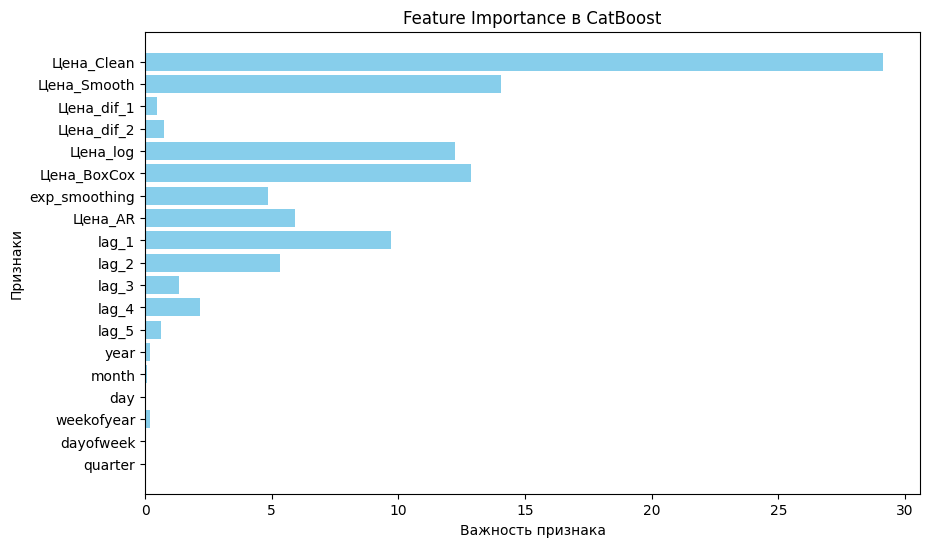

In [35]:
feature_importance = catboost_regressor_model.get_feature_importance()
feature_names = X_train.columns


plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance, color='skyblue')
plt.xlabel("Важность признака")
plt.ylabel("Признаки")
plt.title("Feature Importance в CatBoost")
plt.gca().invert_yaxis()
plt.show()

Модель очень плохо обучена, возможно ей надо добавить признаки. Для этого воспользуемся еще одной таблицей с ценами на сырье

In [ ]:

df_raw_material_price = pd.read_excel('/content/drive/MyDrive/ML_3/Цены на сырье.xlsx')

df_raw_material_price.head()

,dt,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
0,2015-02-09,3850,228,12344,10009,12728,62,NaN,3700.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02-16,3850,206,12271,10432,12852,63,NaN,3700.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2015-02-23,3850,207,12645,11981,13034,64,NaN,3700.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2015-03-02,3850,214,12696,11912,12910,63,NaN,3700.0,72.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN
4,2015-03-09,4400,232,12916,12061,12964,61,NaN,4050.0,70.0,...,NaN,NaN,3540.0,2097.0,1261.0,23.0,NaN,NaN,NaN,NaN


In [ ]:
df_raw_material_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423 entries, 0 to 422
Data columns (total 59 columns):
 #   Column                                                                                            Non-Null Count  Dtype         
---  ------                                                                                            --------------  -----         
 0   dt                                                                                                423 non-null    datetime64[ns]
 1   Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС                                  423 non-null    int64         
 2   Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т                                                          423 non-null    int64         
 3   Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС                                                      423 non-null    int64         
 4   Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС                                      

Получилась полосатая зебра

<Axes: >

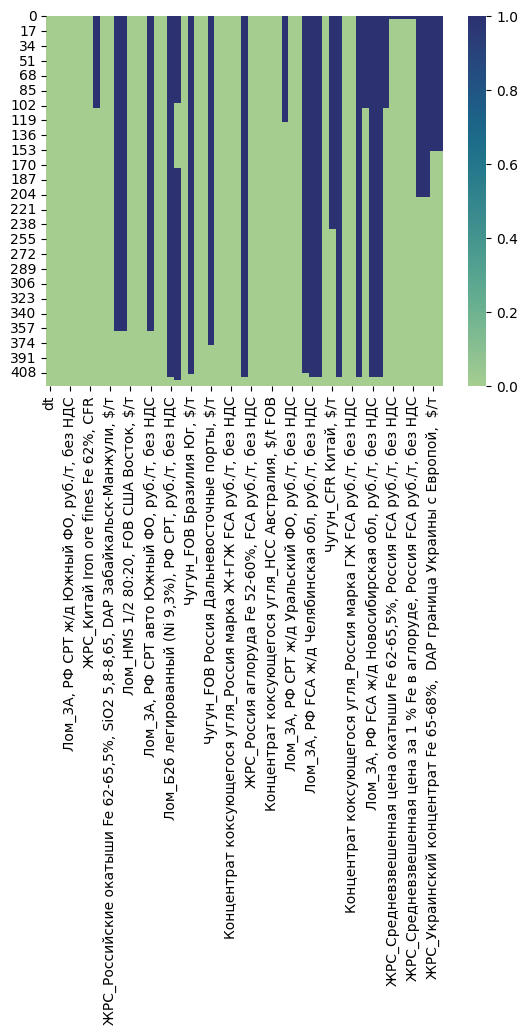

In [ ]:
sns.heatmap(df_raw_material_price.isnull(), cmap='crest')

In [ ]:
df_raw_material_price.columns

Index(['dt',
       'Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС',
       'Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т',
       'Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС',
       'Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС',
       'Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС',
       'ЖРС_Китай Iron ore fines Fe 62%, CFR', 'Чугун_CFR Италия, $/т',
       'Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС',
       'ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т',
       'Лом_3А, РФ CPT авто Центральный ФО, руб./т, без НДС',
       'Лом_3А, РФ CPT авто Уральский ФО, руб./т, без НДС',
       'Лом_HMS 1/2 80:20, FOB США Восток, $/т',
       'Лом_3А, FOB РФ Черное море, $/т', 'Чугун_FOB Бразилия Север, $/т',
       'Лом_3А, РФ CPT авто Южный ФО, руб./т, без НДС',
       'Лом_HMS 1/2 80:20, CFR ЮВА, $/т',
       'Концентрат коксующегося угля_Россия марка КС FCA руб./т, без НДС',
       'Лом_Б26 легированный (

In [ ]:
df_raw_material_price['dt'] = pd.to_datetime(df_raw_material_price['dt'], format='%m-%d-%Y')

df_raw_material_price = df_raw_material_price.set_index(['dt'])

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

for column in df_raw_material_price.columns:
  df_raw_material_price[column] = imputer.fit_transform(df_raw_material_price[[column]])


df_raw_material_price

,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т","Лом_3А, РФ CPT авто Центральный ФО, руб./т, без НДС",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
dt,,,,,,,,,,,,,,,,,,,,,
2015-02-09,3850.0,228.0,12344.0,10009.0,12728.0,62.0,431.336478,3700.0,70.0,22428.225806,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-02-16,3850.0,206.0,12271.0,10432.0,12852.0,63.0,431.336478,3700.0,70.0,22428.225806,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-02-23,3850.0,207.0,12645.0,11981.0,13034.0,64.0,431.336478,3700.0,72.0,22428.225806,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-03-02,3850.0,214.0,12696.0,11912.0,12910.0,63.0,431.336478,3700.0,72.0,22428.225806,...,21682.5,418.937107,3540.000000,2097.000000,1261.000000,23.000000,93.523148,133.078704,108.363806,149.309701
2015-03-09,4400.0,232.0,12916.0,12061.0,12964.0,61.0,431.336478,4050.0,70.0,22428.225806,...,21682.5,418.937107,3540.000000,2097.000000,1261.000000,23.000000,93.523148,133.078704,108.363806,149.309701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,9500.0,399.0,25741.0,23774.0,24100.0,124.0,505.000000,7500.0,136.5,22600.000000,...,22765.0,457.500000,5043.000000,4382.000000,2577.000000,50.000000,66.000000,78.000000,116.000000,154.000000
2023-02-20,9500.0,390.0,25837.0,24060.0,24184.0,124.0,500.000000,7500.0,137.5,22550.000000,...,23414.0,465.000000,5043.000000,4382.000000,2577.000000,50.000000,66.000000,78.000000,116.000000,154.000000
2023-02-27,9500.0,411.0,25814.0,24275.0,24047.0,130.0,502.500000,7500.0,143.0,22400.000000,...,24014.0,455.000000,5547.000000,4898.000000,2921.000000,56.000000,74.000000,85.000000,122.000000,159.000000


<Axes: ylabel='dt'>

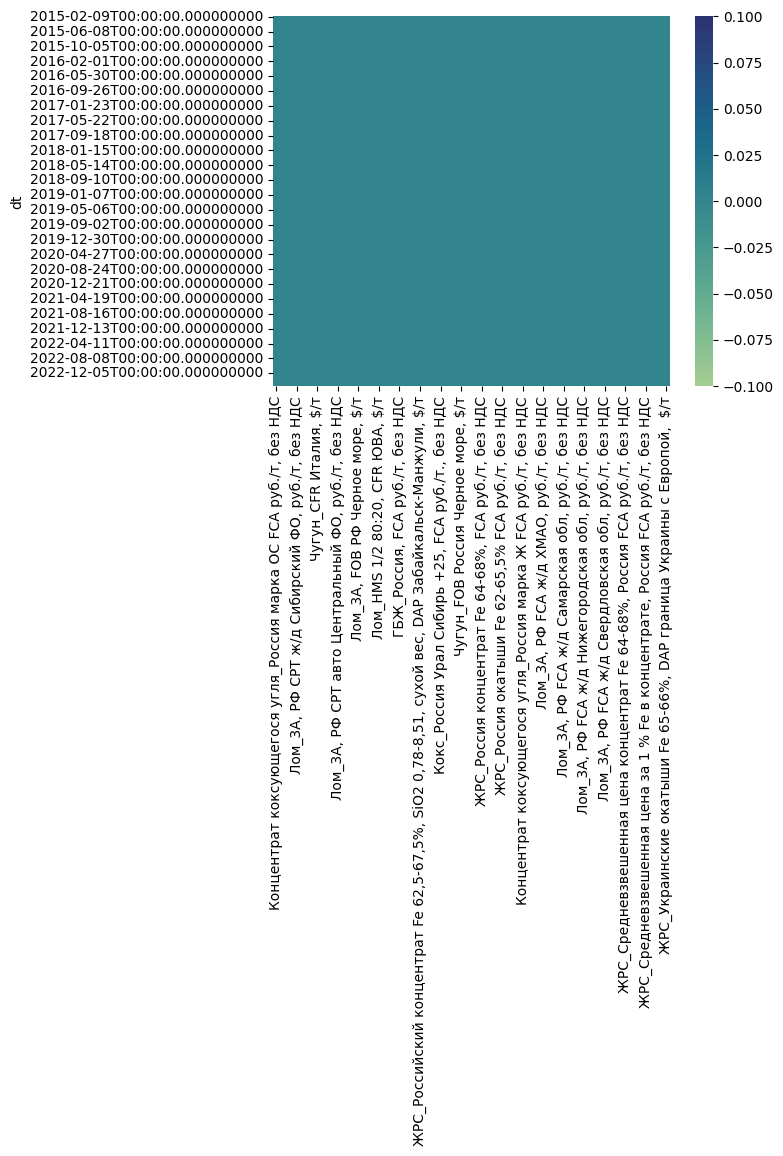

In [ ]:
sns.heatmap(df_raw_material_price.isnull(), cmap='crest')

Склеиваем наши новоиспеченные признаки и основной датафрейм

Теперь надо объединить эти два датафрейма в один, чтобы иметь доступ к новым признакам

In [ ]:
df_raw_material_price.index

DatetimeIndex(['2015-02-09', '2015-02-16', '2015-02-23', '2015-03-02',
               '2015-03-09', '2015-03-16', '2015-03-23', '2015-03-30',
               '2015-04-06', '2015-04-13',
               ...
               '2023-01-09', '2023-01-16', '2023-01-23', '2023-01-30',
               '2023-02-06', '2023-02-13', '2023-02-20', '2023-02-27',
               '2023-03-06', '2023-03-13'],
              dtype='datetime64[ns]', name='dt', length=423, freq=None)

<Axes: ylabel='dt'>

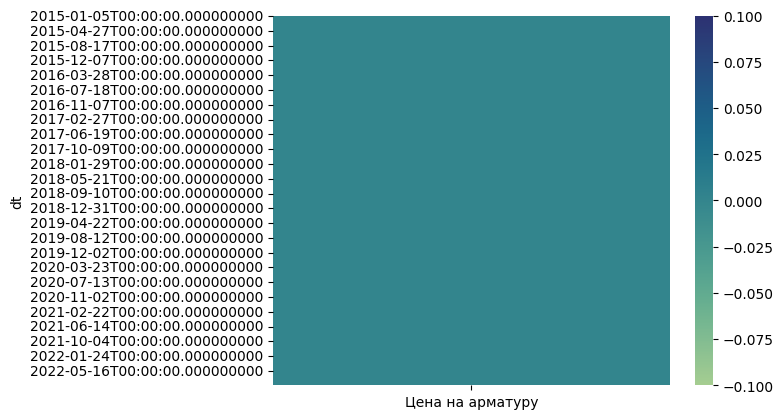

In [ ]:
sns.heatmap(df.isnull(), cmap='crest')

In [ ]:
df.index

DatetimeIndex(['2015-01-05', '2015-01-12', '2015-01-19', '2015-01-26',
               '2015-02-02', '2015-02-09', '2015-02-16', '2015-02-23',
               '2015-03-02', '2015-03-09',
               ...
               '2022-06-27', '2022-07-04', '2022-07-11', '2022-07-18',
               '2022-07-25', '2022-08-01', '2022-08-08', '2022-08-15',
               '2022-08-22', '2022-08-29'],
              dtype='datetime64[ns]', name='dt', length=400, freq=None)

In [ ]:

merged_df = df.join(df_raw_material_price, how='outer')

merged_df

,Цена на арматуру,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-05,32900.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-12,32500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-19,32000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-01-26,30700.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-02,30300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,NaN,9500.0,399.0,25741.0,23774.0,24100.0,124.0,505.0,7500.0,136.5,...,22765.0,457.5,5043.0,4382.0,2577.0,50.0,66.0,78.0,116.0,154.0
2023-02-20,NaN,9500.0,390.0,25837.0,24060.0,24184.0,124.0,500.0,7500.0,137.5,...,23414.0,465.0,5043.0,4382.0,2577.0,50.0,66.0,78.0,116.0,154.0
2023-02-27,NaN,9500.0,411.0,25814.0,24275.0,24047.0,130.0,502.5,7500.0,143.0,...,24014.0,455.0,5547.0,4898.0,2921.0,56.0,74.0,85.0,122.0,159.0


<Axes: ylabel='dt'>

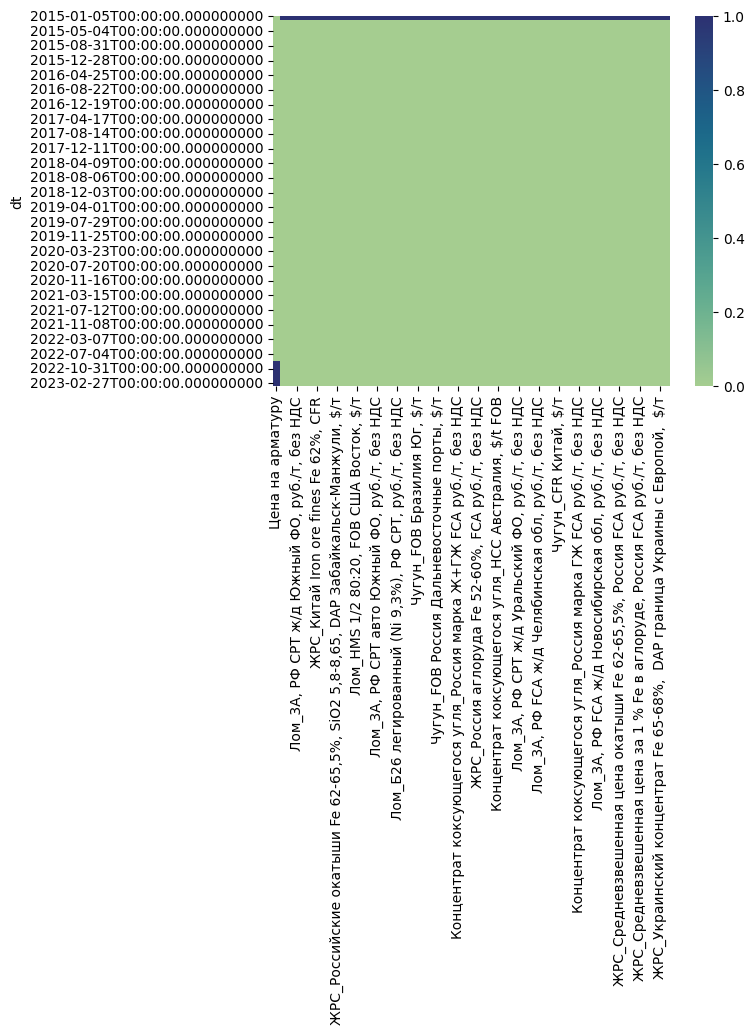

In [ ]:
sns.heatmap(merged_df.isnull(), cmap='crest')

In [ ]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 428 entries, 2015-01-05 to 2023-03-13
Data columns (total 59 columns):
 #   Column                                                                                            Non-Null Count  Dtype  
---  ------                                                                                            --------------  -----  
 0   Цена на арматуру                                                                                  400 non-null    float64
 1   Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС                                  423 non-null    float64
 2   Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т                                                          423 non-null    float64
 3   Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС                                                      423 non-null    float64
 4   Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС                                                  423 non-nul

Еще раз заполняем данные

In [ ]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=2)

for column in merged_df.columns:
  merged_df[column] = imputer.fit_transform(merged_df[[column]])


merged_df

,Цена на арматуру,"Концентрат коксующегося угля_Россия марка ОС FCA руб./т, без НДС","Лом_HMS 1/2 80:20, FOB EC Роттердам, $/т","Лом_3А, РФ CPT ж/д Южный ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Сибирский ФО, руб./т, без НДС","Лом_3А, РФ CPT ж/д Центральный ФО, руб./т, без НДС","ЖРС_Китай Iron ore fines Fe 62%, CFR","Чугун_CFR Италия, $/т","Концентрат коксующегося угля_Россия марка КО FCA руб./т, без НДС","ЖРС_Российские окатыши Fe 62-65,5%, SiO2 5,8-8,65, DAP Забайкальск-Манжули, $/т",...,"Лом_3А, РФ FCA ж/д Свердловская обл, руб./т, без НДС","Чугун_CFR Турция, $/т","ЖРС_Средневзвешенная цена окатыши Fe 62-65,5%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена концентрат Fe 64-68%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена аглоруда Fe 52-60%, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в аглоруде, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в концентрате, Россия FCA руб./т, без НДС","ЖРС_Средневзвешенная цена за 1 % Fe в окатыши, Россия FCA руб./т, без НДС","ЖРС_Украинский концентрат Fe 65-68%, DAP граница Украины с Европой, $/т","ЖРС_Украинские окатыши Fe 65-66%, DAP граница Украины с Европой, $/т"
dt,,,,,,,,,,,,,,,,,,,,,
2015-01-05,32900.000,8615.898345,299.574468,18144.458629,16368.888889,17777.297872,93.07565,431.336478,7163.416076,113.814421,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-01-12,32500.000,8615.898345,299.574468,18144.458629,16368.888889,17777.297872,93.07565,431.336478,7163.416076,113.814421,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-01-19,32000.000,8615.898345,299.574468,18144.458629,16368.888889,17777.297872,93.07565,431.336478,7163.416076,113.814421,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-01-26,30700.000,8615.898345,299.574468,18144.458629,16368.888889,17777.297872,93.07565,431.336478,7163.416076,113.814421,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
2015-02-02,30300.000,8615.898345,299.574468,18144.458629,16368.888889,17777.297872,93.07565,431.336478,7163.416076,113.814421,...,21682.5,418.937107,6237.488095,4541.047619,2540.230952,44.338095,93.523148,133.078704,108.363806,149.309701
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-13,39229.475,9500.000000,399.000000,25741.000000,23774.000000,24100.000000,124.00000,505.000000,7500.000000,136.500000,...,22765.0,457.500000,5043.000000,4382.000000,2577.000000,50.000000,66.000000,78.000000,116.000000,154.000000
2023-02-20,39229.475,9500.000000,390.000000,25837.000000,24060.000000,24184.000000,124.00000,500.000000,7500.000000,137.500000,...,23414.0,465.000000,5043.000000,4382.000000,2577.000000,50.000000,66.000000,78.000000,116.000000,154.000000
2023-02-27,39229.475,9500.000000,411.000000,25814.000000,24275.000000,24047.000000,130.00000,502.500000,7500.000000,143.000000,...,24014.0,455.000000,5547.000000,4898.000000,2921.000000,56.000000,74.000000,85.000000,122.000000,159.000000


Снова проделываем те же операции по разделению обучающей и тестовой выборки

In [ ]:
train_size = int(len(df)*0.7)
train, test = merged_df[:train_size], merged_df[train_size:]

print(f"Размер обучающей выборки: {train.shape}")
print(f"Размер тестовой выборки: {test.shape}")

ну а дальше то же самое и протестировать модель но уже с новыми признаками

<Axes: ylabel='dt'>

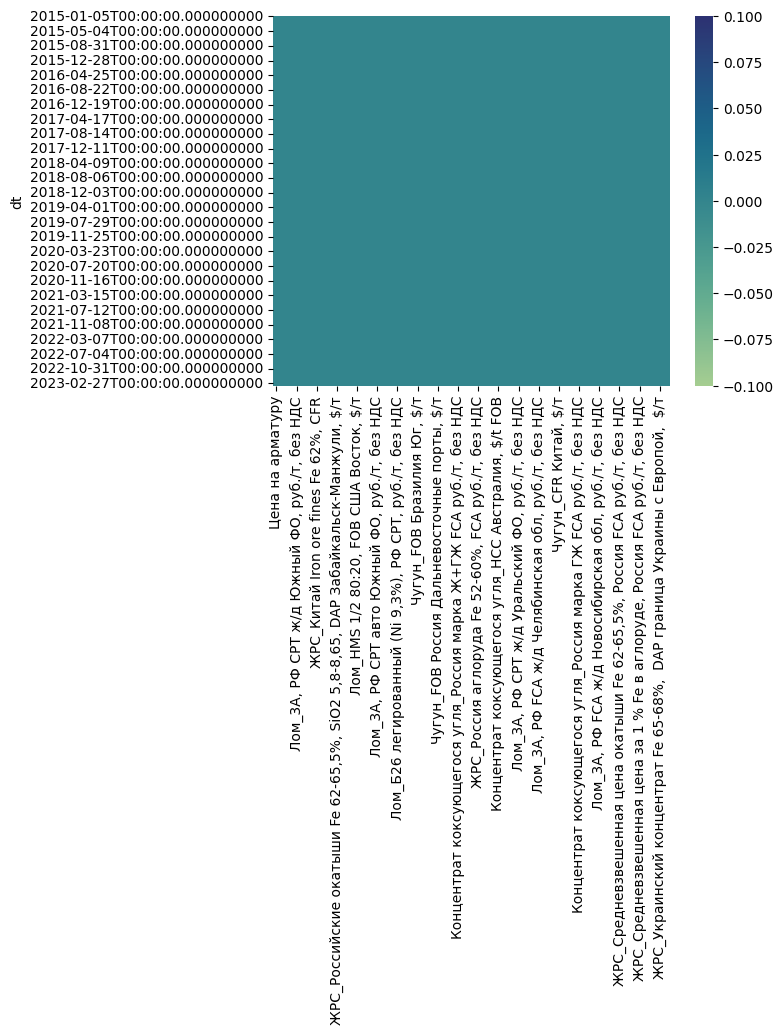

In [ ]:
sns.heatmap(merged_df.isna(), cmap='crest')